In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
import numpy as np
import cv2
import random

In [10]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

Cloning into 'data_complexity_measures'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 71 (delta 34), reused 31 (delta 9), pack-reused 0
Receiving objects: 100% (71/71), 125.53 KiB | 1004.00 KiB/s, done.
Resolving deltas: 100% (34/34), done.


In [11]:
import torch
from torchvision import datasets, transforms
import random
import numpy as np

from data_complexity_measures.models.SeprationIndex import Kalhor_SeparationIndex

# CLAHE

In [25]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Create PyTorch data loaders
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, shuffle=False)

# Check the number of samples in each set
print(f"Combined Train set size: {len(cifar100_train_combined)}")
print(f"Combined Test set size: {len(cifar100_test_combined)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Combined Train set size: 100000
Combined Test set size: 10000


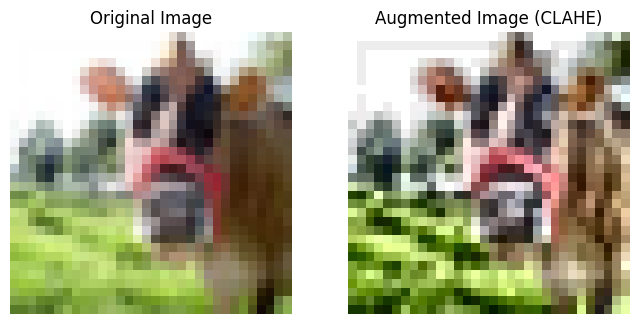

In [35]:
import cv2
import matplotlib.pyplot as plt
from albumentations import CLAHE
from tensorflow.keras.datasets import cifar100

(train_images, _), (_, _) = cifar100.load_data()
image_index = 0
original_image = train_images[image_index]

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

augmentation = CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=1.0)


augmented_image = augmentation(image=original_image)['image']
plt.subplot(1, 2, 2)
plt.title("Augmented Image (CLAHE)")
plt.imshow(augmented_image)
plt.axis('off')

plt.show()


In [24]:
# Load EfficientNetV2-S model
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# 100 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 100)
)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 70.1MB/s]


In [25]:
classifier = model.classifier
print(classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=100, bias=True)
)


In [27]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=4, gamma=0.2)

# Training loop
num_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, val_losses = [], []
train_acc, val_acc = [], []

best_val_acc = 0.0
best_model_path = 'efficientnetv2_s_cifar100_best.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct_train / total_train)

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(running_loss / len(val_loader))
    val_acc.append(100 * correct_val / total_val)


    scheduler.step()

    # Check if the current model has the best validation accuracy
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc[-1]:.2f}%")

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Save model weights
torch.save(model.state_dict(), 'efficientnetv2_s_cifar100_augmented_fiest_method.pth')

Epoch 1/1: 100%|██████████| 25000/25000 [35:25<00:00, 11.76it/s]


Epoch 1/1 | Train Loss: 4.3242 | Train Acc: 4.35% | Val Loss: 47.4367 | Val Acc: 5.06%


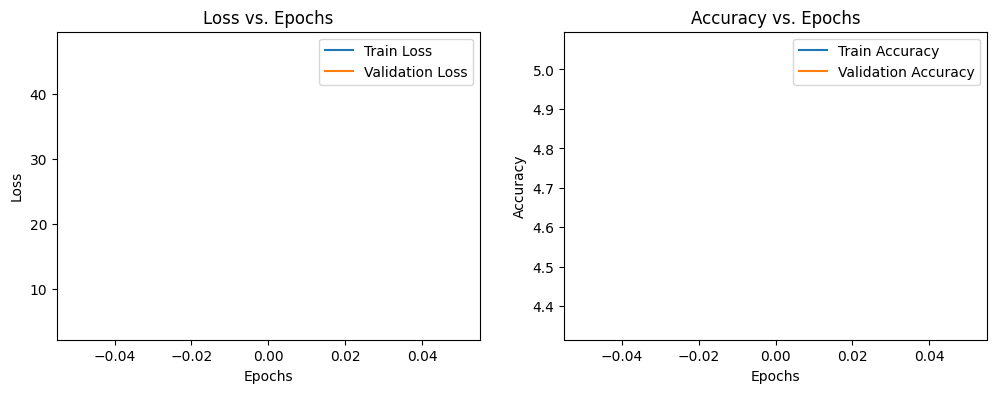

In [28]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

plt.show()

In [ ]:
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


## SI cross for CLAHE

In [39]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Define the size of the balanced subset for both train and test sets
subset_fraction_train = 0.2
subset_fraction_test = 0.2

# Calculate the number of samples needed for the balanced subset for both train and test sets
subset_size_train = int(subset_fraction_train * len(cifar100_train_combined))
subset_size_test = int(subset_fraction_test * len(cifar100_test_combined))

# Create a balanced subset for both train and test sets using SubsetRandomSampler
class_indices_train = list(range(len(cifar100_train_augmented.classes)))
class_indices_test = list(range(len(cifar100_test_augmented.classes)))

class_subset_size_train = int(subset_size_train / len(cifar100_train_augmented.classes))
class_subset_size_test = int(subset_size_test / len(cifar100_test_augmented.classes))

class_sampler_indices_train = []
class_sampler_indices_test = []

for class_index in class_indices_train:
    class_indices_list_train = [i for i, label in enumerate(cifar100_train_augmented.targets) if label == class_index]
    class_sampler_indices_train.extend(class_indices_list_train[:class_subset_size_train])

for class_index in class_indices_test:
    class_indices_list_test = [i for i, label in enumerate(cifar100_test_augmented.targets) if label == class_index]
    class_sampler_indices_test.extend(class_indices_list_test[:class_subset_size_test])

train_sampler = SubsetRandomSampler(class_sampler_indices_train)
test_sampler = SubsetRandomSampler(class_sampler_indices_test)

# Create PyTorch data loaders using the balanced subset for both train and test sets
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, sampler=test_sampler)

# Check the number of samples in each set
print(f"Balanced Train set size: {len(train_loader.sampler)}")
print(f"Balanced Test set size: {len(test_loader.sampler)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Balanced Train set size: 20000
Balanced Test set size: 2000


In [86]:
# Extract data and labels from loaders
cifar100_train_data, cifar100_train_labels = [], []
for data, label in train_loader:
    cifar100_train_data.append(data)
    cifar100_train_labels.append(label)

cifar100_test_data, cifar100_test_labels = [], []
for data, label in test_loader:
    cifar100_test_data.append(data)
    cifar100_test_labels.append(label)

# Concatenate the lists of tensors
cifar100_train_data = torch.cat(cifar100_train_data, dim=0)
cifar100_train_labels = torch.cat(cifar100_train_labels, dim=0)
cifar100_test_data = torch.cat(cifar100_test_data, dim=0)
cifar100_test_labels = torch.cat(cifar100_test_labels, dim=0)

# Convert to desired format
train_data_tensor = cifar100_train_data
train_data_tensor = train_data_tensor.view(train_data_tensor.size(0), -1)

train_label_tensor = cifar100_train_labels.unsqueeze(1)

test_data_tensor = cifar100_test_data
test_data_tensor = test_data_tensor.view(test_data_tensor.size(0), -1)

test_label_tensor = cifar100_test_labels.unsqueeze(1)

In [87]:
train_si_calculator = Kalhor_SeparationIndex(train_data_tensor, train_label_tensor, normalize=True)
test_si_calculator = Kalhor_SeparationIndex(test_data_tensor, test_label_tensor, normalize=True)

data becomes normalized
data becomes normalized


In [88]:
# Calculate cross_si_data for the test dataset
cross_si_data = train_si_calculator.cross_si_data(test_data_tensor, test_label_tensor)
num_ones = torch.sum(cross_si_data == True).item()
total_elements = cross_si_data.numel()
ratio_ones = num_ones / total_elements

print("Cross SI:", ratio_ones)

Cross SI: 0.144


# AdvancedBlur

In [29]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
    A.AdvancedBlur(blur_limit=(3, 7), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1), always_apply=False, p=0.5),
])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Create PyTorch data loaders
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, shuffle=False)

# Check the number of samples in each set
print(f"Combined Train set size: {len(cifar100_train_combined)}")
print(f"Combined Test set size: {len(cifar100_test_combined)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Combined Train set size: 100000
Combined Test set size: 10000


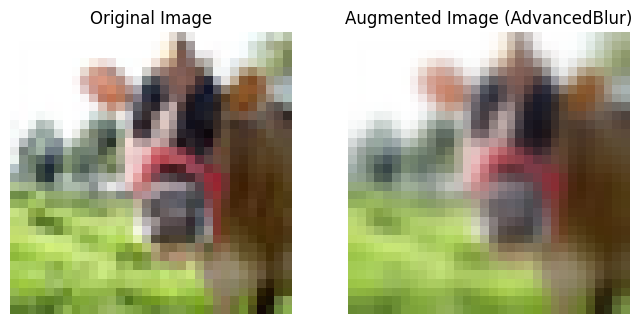

In [40]:
import cv2
import matplotlib.pyplot as plt
from albumentations import AdvancedBlur
from tensorflow.keras.datasets import cifar100

# Load CIFAR-100 dataset
(train_images, _), (_, _) = cifar100.load_data()

# Choose an index for the image you want to augment
image_index = 0
original_image = train_images[image_index]

# Display the original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

# Define the augmentation
augmentation = AdvancedBlur(
    blur_limit=(3, 7),
    sigmaX_limit=(0.2, 1.0),
    sigmaY_limit=(0.2, 1.0),
    rotate_limit=90,
    beta_limit=(0.5, 8.0),
    noise_limit=(0.9, 1.1),
    always_apply=False,
    p=1.0  # Set p=1.0 for always applying the augmentation
)

# Apply augmentation to the image
augmented_image = augmentation(image=original_image)['image']

# Display the augmented image
plt.subplot(1, 2, 2)
plt.title("Augmented Image (AdvancedBlur)")
plt.imshow(augmented_image)
plt.axis('off')

plt.show()


In [ ]:
# Load EfficientNetV2-S model
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# 100 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 100)
)

In [ ]:
classifier = model.classifier
print(classifier)

In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=4, gamma=0.2)

# Training loop
num_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, val_losses = [], []
train_acc, val_acc = [], []

best_val_acc = 0.0
best_model_path = 'efficientnetv2_s_cifar100_best.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct_train / total_train)

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(running_loss / len(val_loader))
    val_acc.append(100 * correct_val / total_val)


    scheduler.step()

    # Check if the current model has the best validation accuracy
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc[-1]:.2f}%")

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Save model weights
torch.save(model.state_dict(), 'efficientnetv2_s_cifar100_augmented_second_method.pth')

## SI cross for AdvancedBlur

In [89]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
    A.AdvancedBlur(blur_limit=(3, 7), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1), always_apply=False, p=0.5),
])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Define the size of the balanced subset for both train and test sets
subset_fraction_train = 0.2
subset_fraction_test = 0.2

# Calculate the number of samples needed for the balanced subset for both train and test sets
subset_size_train = int(subset_fraction_train * len(cifar100_train_combined))
subset_size_test = int(subset_fraction_test * len(cifar100_test_combined))

# Create a balanced subset for both train and test sets using SubsetRandomSampler
class_indices_train = list(range(len(cifar100_train_augmented.classes)))
class_indices_test = list(range(len(cifar100_test_augmented.classes)))

class_subset_size_train = int(subset_size_train / len(cifar100_train_augmented.classes))
class_subset_size_test = int(subset_size_test / len(cifar100_test_augmented.classes))

class_sampler_indices_train = []
class_sampler_indices_test = []

for class_index in class_indices_train:
    class_indices_list_train = [i for i, label in enumerate(cifar100_train_augmented.targets) if label == class_index]
    class_sampler_indices_train.extend(class_indices_list_train[:class_subset_size_train])

for class_index in class_indices_test:
    class_indices_list_test = [i for i, label in enumerate(cifar100_test_augmented.targets) if label == class_index]
    class_sampler_indices_test.extend(class_indices_list_test[:class_subset_size_test])

train_sampler = SubsetRandomSampler(class_sampler_indices_train)
test_sampler = SubsetRandomSampler(class_sampler_indices_test)

# Create PyTorch data loaders using the balanced subset for both train and test sets
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, sampler=test_sampler)

# Check the number of samples in each set
print(f"Balanced Train set size: {len(train_loader.sampler)}")
print(f"Balanced Test set size: {len(test_loader.sampler)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Balanced Train set size: 20000
Balanced Test set size: 2000


In [90]:
# Extract data and labels from loaders
cifar100_train_data, cifar100_train_labels = [], []
for data, label in train_loader:
    cifar100_train_data.append(data)
    cifar100_train_labels.append(label)

cifar100_test_data, cifar100_test_labels = [], []
for data, label in test_loader:
    cifar100_test_data.append(data)
    cifar100_test_labels.append(label)

# Concatenate the lists of tensors
cifar100_train_data = torch.cat(cifar100_train_data, dim=0)
cifar100_train_labels = torch.cat(cifar100_train_labels, dim=0)
cifar100_test_data = torch.cat(cifar100_test_data, dim=0)
cifar100_test_labels = torch.cat(cifar100_test_labels, dim=0)

# Convert to desired format
train_data_tensor = cifar100_train_data
train_data_tensor = train_data_tensor.view(train_data_tensor.size(0), -1)

train_label_tensor = cifar100_train_labels.unsqueeze(1)

test_data_tensor = cifar100_test_data
test_data_tensor = test_data_tensor.view(test_data_tensor.size(0), -1)

test_label_tensor = cifar100_test_labels.unsqueeze(1)

In [91]:
train_si_calculator = Kalhor_SeparationIndex(train_data_tensor, train_label_tensor, normalize=True)
test_si_calculator = Kalhor_SeparationIndex(test_data_tensor, test_label_tensor, normalize=True)

data becomes normalized
data becomes normalized


In [92]:
# Calculate cross_si_data for the test dataset
cross_si_data = train_si_calculator.cross_si_data(test_data_tensor, test_label_tensor)
num_ones = torch.sum(cross_si_data == True).item()
total_elements = cross_si_data.numel()
ratio_ones = num_ones / total_elements

print("Cross SI:", ratio_ones)

Cross SI: 0.144


# GaussNoise

In [30]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
    A.GaussNoise (var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.5)
])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Create PyTorch data loaders
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, shuffle=False)

# Check the number of samples in each set
print(f"Combined Train set size: {len(cifar100_train_combined)}")
print(f"Combined Test set size: {len(cifar100_test_combined)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Combined Train set size: 100000
Combined Test set size: 10000


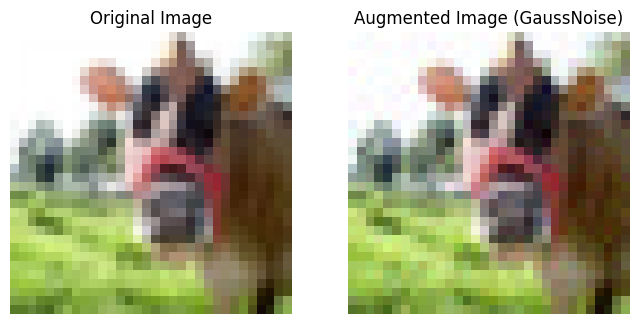

In [43]:
import cv2
import matplotlib.pyplot as plt
from albumentations import GaussNoise
from tensorflow.keras.datasets import cifar100

# Load CIFAR-100 dataset
(train_images, _), (_, _) = cifar100.load_data()

# Choose an index for the image you want to augment
image_index = 0
original_image = train_images[image_index]

# Display the original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

# Define the augmentation
augmentation = GaussNoise(
    var_limit=(10.0, 50.0),
    mean=0,
    per_channel=True,
    always_apply=False,
    p=1.0  # Set p=1.0 for always applying the augmentation
)

# Apply augmentation to the image
augmented_image = augmentation(image=original_image)['image']

# Display the augmented image
plt.subplot(1, 2, 2)
plt.title("Augmented Image (GaussNoise)")
plt.imshow(augmented_image)
plt.axis('off')

plt.show()


In [ ]:
# Load EfficientNetV2-S model
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# 100 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 100)
)

In [ ]:
classifier = model.classifier
print(classifier)

In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=4, gamma=0.2)

# Training loop
num_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, val_losses = [], []
train_acc, val_acc = [], []

best_val_acc = 0.0
best_model_path = 'efficientnetv2_s_cifar100_best.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct_train / total_train)

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(running_loss / len(val_loader))
    val_acc.append(100 * correct_val / total_val)


    scheduler.step()

    # Check if the current model has the best validation accuracy
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc[-1]:.2f}%")

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Save model weights
torch.save(model.state_dict(), 'efficientnetv2_s_cifar100_augmented_third_method.pth')

## SI cross for GaussNoise

In [20]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
    A.GaussNoise (var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.5)
])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Define the size of the balanced subset for both train and test sets
subset_fraction_train = 0.2
subset_fraction_test = 0.2

# Calculate the number of samples needed for the balanced subset for both train and test sets
subset_size_train = int(subset_fraction_train * len(cifar100_train_combined))
subset_size_test = int(subset_fraction_test * len(cifar100_test_combined))

# Create a balanced subset for both train and test sets using SubsetRandomSampler
class_indices_train = list(range(len(cifar100_train_augmented.classes)))
class_indices_test = list(range(len(cifar100_test_augmented.classes)))

class_subset_size_train = int(subset_size_train / len(cifar100_train_augmented.classes))
class_subset_size_test = int(subset_size_test / len(cifar100_test_augmented.classes))

class_sampler_indices_train = []
class_sampler_indices_test = []

for class_index in class_indices_train:
    class_indices_list_train = [i for i, label in enumerate(cifar100_train_augmented.targets) if label == class_index]
    class_sampler_indices_train.extend(class_indices_list_train[:class_subset_size_train])

for class_index in class_indices_test:
    class_indices_list_test = [i for i, label in enumerate(cifar100_test_augmented.targets) if label == class_index]
    class_sampler_indices_test.extend(class_indices_list_test[:class_subset_size_test])

train_sampler = SubsetRandomSampler(class_sampler_indices_train)
test_sampler = SubsetRandomSampler(class_sampler_indices_test)

# Create PyTorch data loaders using the balanced subset for both train and test sets
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, sampler=test_sampler)

# Check the number of samples in each set
print(f"Balanced Train set size: {len(train_loader.sampler)}")
print(f"Balanced Test set size: {len(test_loader.sampler)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Balanced Train set size: 20000
Balanced Test set size: 2000


In [21]:
# Extract data and labels from loaders
cifar100_train_data, cifar100_train_labels = [], []
for data, label in train_loader:
    cifar100_train_data.append(data)
    cifar100_train_labels.append(label)

cifar100_test_data, cifar100_test_labels = [], []
for data, label in test_loader:
    cifar100_test_data.append(data)
    cifar100_test_labels.append(label)

# Concatenate the lists of tensors
cifar100_train_data = torch.cat(cifar100_train_data, dim=0)
cifar100_train_labels = torch.cat(cifar100_train_labels, dim=0)
cifar100_test_data = torch.cat(cifar100_test_data, dim=0)
cifar100_test_labels = torch.cat(cifar100_test_labels, dim=0)

# Convert to desired format
train_data_tensor = cifar100_train_data
train_data_tensor = train_data_tensor.view(train_data_tensor.size(0), -1)

train_label_tensor = cifar100_train_labels.unsqueeze(1)

test_data_tensor = cifar100_test_data
test_data_tensor = test_data_tensor.view(test_data_tensor.size(0), -1)

test_label_tensor = cifar100_test_labels.unsqueeze(1)

In [22]:
train_si_calculator = Kalhor_SeparationIndex(train_data_tensor, train_label_tensor, normalize=True)
test_si_calculator = Kalhor_SeparationIndex(test_data_tensor, test_label_tensor, normalize=True)

data becomes normalized
data becomes normalized


In [23]:
# Calculate cross_si_data for the test dataset
cross_si_data = train_si_calculator.cross_si_data(test_data_tensor, test_label_tensor)
num_ones = torch.sum(cross_si_data == True).item()
total_elements = cross_si_data.numel()
ratio_ones = num_ones / total_elements

print("Cross SI:", ratio_ones)

Cross SI: 0.144


# RandomRain

In [31]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
    A.RandomRain(slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(200, 200, 200), blur_value=7, brightness_coefficient=0.7, rain_type=None, always_apply=False, p=0.5)
])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Create PyTorch data loaders
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, shuffle=False)

# Check the number of samples in each set
print(f"Combined Train set size: {len(cifar100_train_combined)}")
print(f"Combined Test set size: {len(cifar100_test_combined)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Combined Train set size: 100000
Combined Test set size: 10000


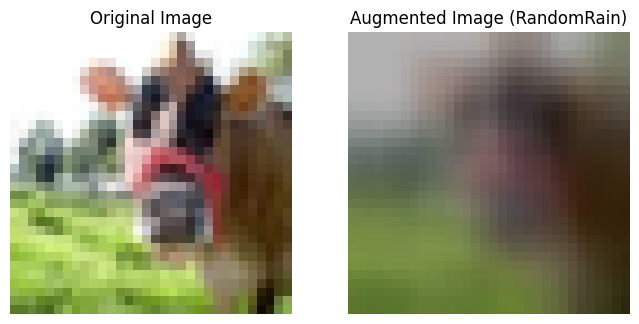

In [44]:
import cv2
import matplotlib.pyplot as plt
from albumentations import RandomRain
from tensorflow.keras.datasets import cifar100

# Load CIFAR-100 dataset
(train_images, _), (_, _) = cifar100.load_data()

# Choose an index for the image you want to augment
image_index = 0
original_image = train_images[image_index]

# Display the original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

# Define the augmentation
augmentation = RandomRain(
    slant_lower=-10,
    slant_upper=10,
    drop_length=20,
    drop_width=1,
    drop_color=(200, 200, 200),
    blur_value=7,
    brightness_coefficient=0.7,
    rain_type=None,
    always_apply=False,
    p=1.0  # Set p=1.0 for always applying the augmentation
)

# Apply augmentation to the image
augmented_image = augmentation(image=original_image)['image']

# Display the augmented image
plt.subplot(1, 2, 2)
plt.title("Augmented Image (RandomRain)")
plt.imshow(augmented_image)
plt.axis('off')

plt.show()


In [ ]:
# Load EfficientNetV2-S model
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# 100 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 100)
)

In [ ]:
classifier = model.classifier
print(classifier)

In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=4, gamma=0.2)

# Training loop
num_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, val_losses = [], []
train_acc, val_acc = [], []

best_val_acc = 0.0
best_model_path = 'efficientnetv2_s_cifar100_best.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct_train / total_train)

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(running_loss / len(val_loader))
    val_acc.append(100 * correct_val / total_val)


    scheduler.step()

    # Check if the current model has the best validation accuracy
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc[-1]:.2f}%")

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Save model weights
torch.save(model.state_dict(), 'efficientnetv2_s_cifar100_augmented_fourth_method.pth')

## SI cross for RandomRain

In [16]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
    A.RandomRain(slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(200, 200, 200), blur_value=7, brightness_coefficient=0.7, rain_type=None, always_apply=False, p=0.5)
])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Define the size of the balanced subset for both train and test sets
subset_fraction_train = 0.2
subset_fraction_test = 0.2

# Calculate the number of samples needed for the balanced subset for both train and test sets
subset_size_train = int(subset_fraction_train * len(cifar100_train_combined))
subset_size_test = int(subset_fraction_test * len(cifar100_test_combined))

# Create a balanced subset for both train and test sets using SubsetRandomSampler
class_indices_train = list(range(len(cifar100_train_augmented.classes)))
class_indices_test = list(range(len(cifar100_test_augmented.classes)))

class_subset_size_train = int(subset_size_train / len(cifar100_train_augmented.classes))
class_subset_size_test = int(subset_size_test / len(cifar100_test_augmented.classes))

class_sampler_indices_train = []
class_sampler_indices_test = []

for class_index in class_indices_train:
    class_indices_list_train = [i for i, label in enumerate(cifar100_train_augmented.targets) if label == class_index]
    class_sampler_indices_train.extend(class_indices_list_train[:class_subset_size_train])

for class_index in class_indices_test:
    class_indices_list_test = [i for i, label in enumerate(cifar100_test_augmented.targets) if label == class_index]
    class_sampler_indices_test.extend(class_indices_list_test[:class_subset_size_test])

train_sampler = SubsetRandomSampler(class_sampler_indices_train)
test_sampler = SubsetRandomSampler(class_sampler_indices_test)

# Create PyTorch data loaders using the balanced subset for both train and test sets
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, sampler=test_sampler)

# Check the number of samples in each set
print(f"Balanced Train set size: {len(train_loader.sampler)}")
print(f"Balanced Test set size: {len(test_loader.sampler)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Balanced Train set size: 20000
Balanced Test set size: 2000


In [17]:
# Extract data and labels from loaders
cifar100_train_data, cifar100_train_labels = [], []
for data, label in train_loader:
    cifar100_train_data.append(data)
    cifar100_train_labels.append(label)

cifar100_test_data, cifar100_test_labels = [], []
for data, label in test_loader:
    cifar100_test_data.append(data)
    cifar100_test_labels.append(label)

# Concatenate the lists of tensors
cifar100_train_data = torch.cat(cifar100_train_data, dim=0)
cifar100_train_labels = torch.cat(cifar100_train_labels, dim=0)
cifar100_test_data = torch.cat(cifar100_test_data, dim=0)
cifar100_test_labels = torch.cat(cifar100_test_labels, dim=0)

# Convert to desired format
train_data_tensor = cifar100_train_data
train_data_tensor = train_data_tensor.view(train_data_tensor.size(0), -1)

train_label_tensor = cifar100_train_labels.unsqueeze(1)

test_data_tensor = cifar100_test_data
test_data_tensor = test_data_tensor.view(test_data_tensor.size(0), -1)

test_label_tensor = cifar100_test_labels.unsqueeze(1)

In [18]:
train_si_calculator = Kalhor_SeparationIndex(train_data_tensor, train_label_tensor, normalize=True)
test_si_calculator = Kalhor_SeparationIndex(test_data_tensor, test_label_tensor, normalize=True)

data becomes normalized
data becomes normalized


In [19]:
# Calculate cross_si_data for the test dataset
cross_si_data = train_si_calculator.cross_si_data(test_data_tensor, test_label_tensor)
num_ones = torch.sum(cross_si_data == True).item()
total_elements = cross_si_data.numel()
ratio_ones = num_ones / total_elements

print("Cross SI:", ratio_ones)

Cross SI: 0.144


# ToGray

In [32]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
     A.ToGray()
     ])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Create PyTorch data loaders
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, shuffle=False)

# Check the number of samples in each set
print(f"Combined Train set size: {len(cifar100_train_combined)}")
print(f"Combined Test set size: {len(cifar100_test_combined)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Combined Train set size: 100000
Combined Test set size: 10000


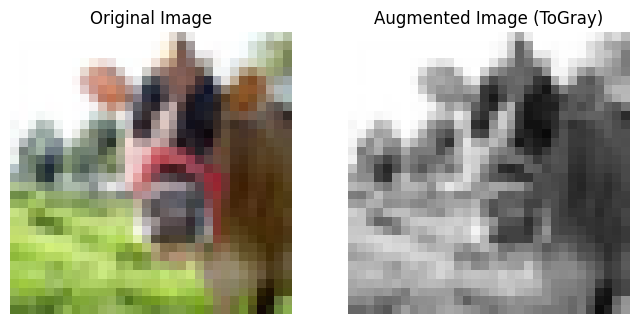

In [45]:
import cv2
import matplotlib.pyplot as plt
from albumentations import ToGray
from tensorflow.keras.datasets import cifar100

# Load CIFAR-100 dataset
(train_images, _), (_, _) = cifar100.load_data()

# Choose an index for the image you want to augment
image_index = 0
original_image = train_images[image_index]

# Display the original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

# Define the augmentation
augmentation = ToGray(always_apply=False, p=1.0)  # Set p=1.0 for always applying the augmentation

# Apply augmentation to the image
augmented_image = augmentation(image=original_image)['image']

# Display the augmented image
plt.subplot(1, 2, 2)
plt.title("Augmented Image (ToGray)")
plt.imshow(augmented_image, cmap='gray')
plt.axis('off')

plt.show()


In [ ]:
# Load EfficientNetV2-S model
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# 100 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 100)
)

In [ ]:
classifier = model.classifier
print(classifier)

In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=4, gamma=0.2)

# Training loop
num_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, val_losses = [], []
train_acc, val_acc = [], []

best_val_acc = 0.0
best_model_path = 'efficientnetv2_s_cifar100_best.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct_train / total_train)

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(running_loss / len(val_loader))
    val_acc.append(100 * correct_val / total_val)


    scheduler.step()

    # Check if the current model has the best validation accuracy
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc[-1]:.2f}%")

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Save model weights
torch.save(model.state_dict(), 'efficientnetv2_s_cifar100_augmented_fifth_method.pth')

## SI cross for ToGray

In [12]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
     A.ToGray()
])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Define the size of the balanced subset for both train and test sets
subset_fraction_train = 0.2
subset_fraction_test = 0.2

# Calculate the number of samples needed for the balanced subset for both train and test sets
subset_size_train = int(subset_fraction_train * len(cifar100_train_combined))
subset_size_test = int(subset_fraction_test * len(cifar100_test_combined))

# Create a balanced subset for both train and test sets using SubsetRandomSampler
class_indices_train = list(range(len(cifar100_train_augmented.classes)))
class_indices_test = list(range(len(cifar100_test_augmented.classes)))

class_subset_size_train = int(subset_size_train / len(cifar100_train_augmented.classes))
class_subset_size_test = int(subset_size_test / len(cifar100_test_augmented.classes))

class_sampler_indices_train = []
class_sampler_indices_test = []

for class_index in class_indices_train:
    class_indices_list_train = [i for i, label in enumerate(cifar100_train_augmented.targets) if label == class_index]
    class_sampler_indices_train.extend(class_indices_list_train[:class_subset_size_train])

for class_index in class_indices_test:
    class_indices_list_test = [i for i, label in enumerate(cifar100_test_augmented.targets) if label == class_index]
    class_sampler_indices_test.extend(class_indices_list_test[:class_subset_size_test])

train_sampler = SubsetRandomSampler(class_sampler_indices_train)
test_sampler = SubsetRandomSampler(class_sampler_indices_test)

# Create PyTorch data loaders using the balanced subset for both train and test sets
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, sampler=test_sampler)

# Check the number of samples in each set
print(f"Balanced Train set size: {len(train_loader.sampler)}")
print(f"Balanced Test set size: {len(test_loader.sampler)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Balanced Train set size: 20000
Balanced Test set size: 2000


In [13]:
# Extract data and labels from loaders
cifar100_train_data, cifar100_train_labels = [], []
for data, label in train_loader:
    cifar100_train_data.append(data)
    cifar100_train_labels.append(label)

cifar100_test_data, cifar100_test_labels = [], []
for data, label in test_loader:
    cifar100_test_data.append(data)
    cifar100_test_labels.append(label)

# Concatenate the lists of tensors
cifar100_train_data = torch.cat(cifar100_train_data, dim=0)
cifar100_train_labels = torch.cat(cifar100_train_labels, dim=0)
cifar100_test_data = torch.cat(cifar100_test_data, dim=0)
cifar100_test_labels = torch.cat(cifar100_test_labels, dim=0)

# Convert to desired format
train_data_tensor = cifar100_train_data
train_data_tensor = train_data_tensor.view(train_data_tensor.size(0), -1)

train_label_tensor = cifar100_train_labels.unsqueeze(1)

test_data_tensor = cifar100_test_data
test_data_tensor = test_data_tensor.view(test_data_tensor.size(0), -1)

test_label_tensor = cifar100_test_labels.unsqueeze(1)

In [14]:
train_si_calculator = Kalhor_SeparationIndex(train_data_tensor, train_label_tensor, normalize=True)
test_si_calculator = Kalhor_SeparationIndex(test_data_tensor, test_label_tensor, normalize=True)

data becomes normalized
data becomes normalized


In [15]:
# Calculate cross_si_data for the test dataset
cross_si_data = train_si_calculator.cross_si_data(test_data_tensor, test_label_tensor)
num_ones = torch.sum(cross_si_data == True).item()
total_elements = cross_si_data.numel()
ratio_ones = num_ones / total_elements

print("Cross SI:", ratio_ones)

Cross SI: 0.144
